In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np  
import pandas as pd    
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from time import time
from platform_sdk.dataset_reader import DatasetReader
from datetime import date

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, TimeSeriesSplit, RepeatedKFold, train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

INFO:matplotlib.font_manager:generated new fontManager


# DATA LOADING

In [5]:
dataset_reader = DatasetReader(get_platform_sdk_client_context(), dataset_id="6144b1cba3485119497a6f86")
# To filter your data using a date range, visit the Python data access guide here: http://www.adobe.com/go/jupyterlab-notebook-python-filter-data-en
titanic = dataset_reader.limit(10000000).read()

INFO:PlatformSDKPython:dataset_reader: seconds taken to get dataset details from catalog and make PQS connection: 0.15
INFO:PlatformSDKPython:dataset_id: 6144b1cba3485119497a6f86, limit: 10000000
INFO:PlatformSDKPython:dataset_reader: seconds taken to execute query: 25.82
INFO:PlatformSDKPython:dataset_reader: 891 rows read. 143.8 MB memory used for this process
INFO:PlatformSDKPython:dataset_reader: seconds taken to format data of dataframe: 0.02


Titanic Dataset Summary:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


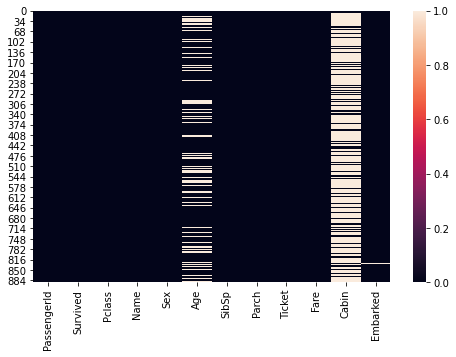

In [6]:
print("Titanic Dataset Summary:")
display(titanic.head())
plt.figure(figsize=(8,5))
sns.heatmap(titanic.isnull())# Heatmap of missing values
plt.show() 

# FEATURE PREPROCESSING

In [7]:
# creating a new feature (Title) by extracting title from the Name feature

titanic['Title'] = titanic.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
new_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

titanic.Title = titanic.Title.map(new_titles)

titanic.Cabin = titanic.Cabin.fillna(0)
for i in range(len(titanic.Cabin)): 
    if titanic.Cabin[i] != 0:
        titanic.Cabin[i] = 1

grouped = titanic.groupby(['Sex','Pclass', 'Title'])
titanic.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

most_embarked = titanic.Embarked.value_counts().index[0]
titanic.Embarked = titanic.Embarked.fillna(most_embarked)
titanic.Fare = titanic.Fare.fillna(titanic.Fare.median())
                                      
titanic.drop('Name', axis =1, inplace=True)
titanic.drop('Ticket', axis =1, inplace=True)
titanic.drop('PassengerId', axis=1, inplace = True)

Sex = {"male": 0, "female":1}
titanic["Sex"] = titanic.Sex.map(Sex)

titanic['SibSp'] = titanic['SibSp'].apply(lambda x: int(x))
titanic['Parch'] = titanic['Parch'].apply(lambda x: int(x))

titanic['Partner'] = titanic['SibSp'] + titanic['Parch'] 
titanic.drop(['SibSp', 'Parch'], axis=1, inplace=True)
titanic = pd.get_dummies(titanic, columns = ['Title','Embarked'])

In [12]:
display(titanic.head())

,Survived,Pclass,Sex,Age,Fare,Cabin,Partner,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22,7.25,0,1,0,0,1,0,0,0,0,0,1
1,1,1,1,38,71.2833,1,1,0,0,0,1,0,0,1,0,0
2,1,3,1,26,7.925,0,0,0,1,0,0,0,0,0,0,1
3,1,1,1,35,53.1,1,1,0,0,0,1,0,0,0,0,1
4,0,3,0,35,8.05,0,0,0,0,1,0,0,0,0,0,1


# MODEL CREATION & TRAINING

In [11]:
y = titanic.Survived
X = titanic.drop(columns = ['Survived'])
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

(891, 15)
(891,)


In [13]:
# DECISION TREE

# define model
decision_tree = DecisionTreeClassifier()

# define parameters
criterion = ['gini','entropy']
max_depth = [2,3,4,5,6,7,8,9,10]

# define grid search
grid = dict(criterion=criterion, max_depth=max_depth)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [14]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 6}

# TESTING RESULTS

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       107
           1       0.88      0.58      0.70        72

    accuracy                           0.80       179
   macro avg       0.82      0.76      0.77       179
weighted avg       0.81      0.80      0.79       179

<class 'str'>


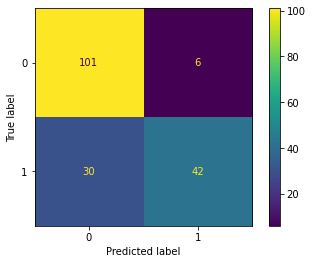

In [15]:
# prediction
y_pred = grid_search.predict(X_test)

# classification results report
print(classification_report(y_test, y_pred))
print(type(classification_report(y_test, y_pred)))

# confusion matrix
plot_confusion_matrix(grid_result, X_test, y_test)